In [1]:
import pandas as pd
import geojson as gj
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
import utils

In [2]:
nodes_gdf = gpd.read_file('Scigrid_data/IGGIN_Nodes.geojson')
nodes_gdf.head()

,name,id,country_code,tags,param,method,geometry
0,N_0,NO_N_0,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (6.79720 65.10640)
1,N_1,NO_N_1,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (5.19357 59.33286)
2,N_2,NO_N_2,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89575 60.56023)
3,N_3,NO_N_3,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89614 60.78219)
4,N_4,NO_N_4,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (3.29837 54.78877)


In [3]:
pipelines_df = utils.get_IGGIN_pipeline_data()
pipelines_df.head()

,id,name,source_id,lat,long,comment,tags,geometry,diameter_mm,end_year,...,method_long_mean,method_max_cap_M_m3_per_d,method_max_pressure_bar,method_num_compressor,method_start_year,method_waterDepth_m,country_code_1,country_code_2,node_id_1,node_id_2
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"[39.3900748, 38.892435]","[-3.3500984, -1.719831]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_23,INET_N_295
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"[40.01, 40.223]","[-3.207, -3.681]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_1460,INET_N_904
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"[44.991076, 44.90008]","[9.920891, 8.60944]",None,{},None,914.400000,2050,...,make_Attrib(latlong_mean),Lasso,raw,Median,make_Attrib(const),Lasso,IT,IT,INET_N_317,INET_N_26
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"[38.711202, 38.87665]","[-6.382539, -6.9714]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_108
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"[38.711202, 41.506]","[-6.382539, -5.644]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_1653


## Add attributes (physical properties) to pipelines

In [4]:
# Create a graph of the pipeline network
G = nx.DiGraph()

# Add the nodes to the graph
for i, row in nodes_gdf.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y), country_code=row['country_code'], is_country_node=False)

# Add the edges to the graph
for i, row in pipelines_df.iterrows():
    if row['node_id_1'] == row['node_id_2']:
        continue
    G.add_edge(row['node_id_1'], row['node_id_2'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_1'],
                                                    country_code_2= row['country_code_2'],
                                                    name= row['name'])

## Add country nodes to the grid

In [5]:
country_positions = {}

for node_id, node_data in G.nodes(data=True):
    country_code = node_data.get('country_code')
    if country_code is not None:
        country_code = str.strip(country_code.upper())
    
    if country_code not in country_positions:
        country_positions[country_code] = []
    country_positions[country_code].append(node_data['pos'])

for country_code, positions in country_positions.items():
    average_position = np.mean(positions, axis=0)
    G.add_node(country_code, pos=average_position, is_country_node=True, country_code=country_code)

for node_id, node_data in G.nodes(data=True):
    if 'country_node' in node_data:
        G.remove_node(node_id)

## Direct dead-end flow from nodes to their respective country nodes (i.e. super sinks)

In [6]:
# Get the list of country nodes
country_nodes = [node_id for node_id, node_data in G.nodes(data=True) if node_data.get('is_country_node')]

# Iterate over each node in the graph
for node_id, node_data in G.nodes(data=True):
    # Skip country nodes
    if node_data.get('is_country_node'):
        continue
    
    # Get the country code of the node
    country_code = node_data.get('country_code')
    
    # Find the corresponding country super node
    country_super_node = next((cn for cn in country_nodes if G.nodes[cn]['country_code'] == country_code), None)
    
    if country_super_node:
        # Check if the node is a sink (only incoming edges)
        if G.in_degree(node_id) > 0 and G.out_degree(node_id) == 0:
            # Calculate the aggregate in-degree capacity of the child node
            aggregate_in_capacity = sum(G.edges[neighbor, node_id]['capacity'] for neighbor in G.predecessors(node_id))
            
            # Add an edge directed towards the country node from the node with the aggregate in-degree capacity
            G.add_edge(node_id, country_super_node, capacity = aggregate_in_capacity)
        
        
        # Check if the node is a source (only outgoing edges)
        if G.in_degree(node_id) == 0 and G.out_degree(node_id) > 0:
            # Calculate the aggregate out-degree capacity of the child node
            aggregate_out_capacity = sum(G.edges[node_id, neighbor]['capacity'] for neighbor in G.successors(node_id))
            
            # Add an edge directed towards the node from the country node with the aggregate out-degree capacity
            G.add_edge(country_super_node, node_id, capacity = aggregate_out_capacity) 


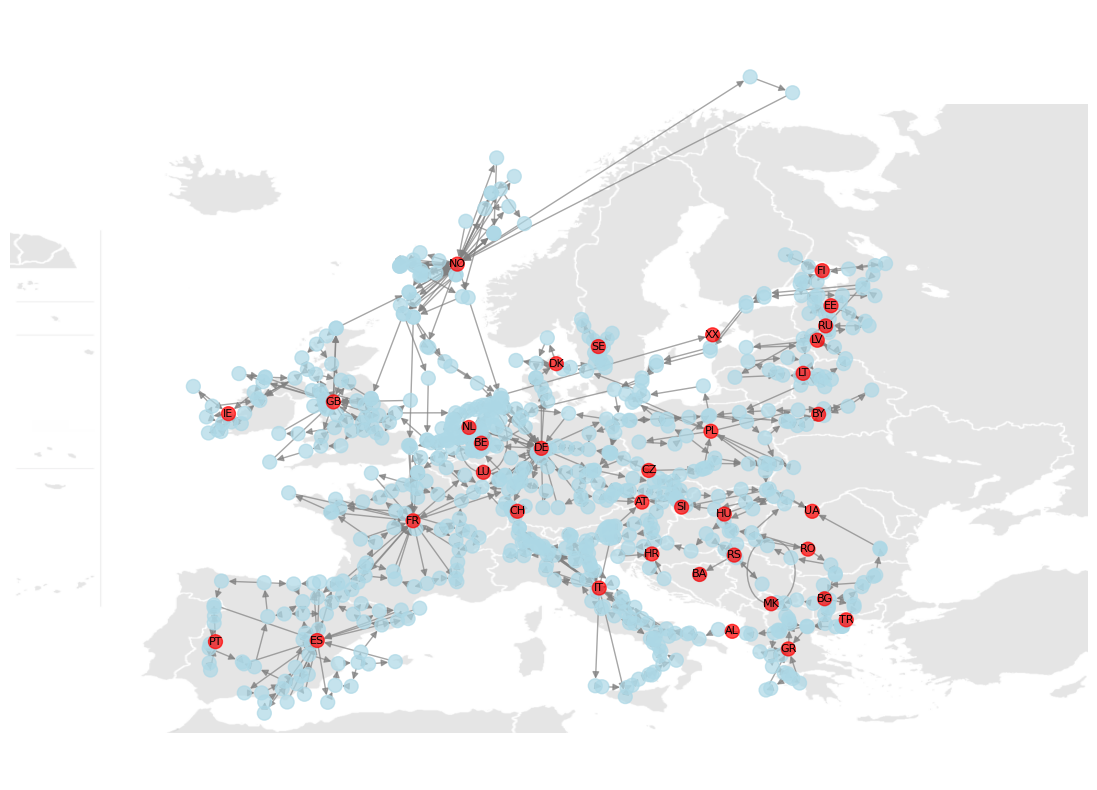

In [7]:
import matplotlib.image as mpimg
europe_map = mpimg.imread('Europe_blank_map.png')

plt.figure(figsize=(15, 10))
plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

pos = nx.get_node_attributes(G, 'pos')
node_colors = ['red' if G.nodes[node_id].get('is_country_node') else 'lightblue' for node_id in G.nodes]
nx.draw(G, pos=pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', width=1, alpha=0.7)

country_nodes = [node_id for node_id, node_data in G.nodes(data=True) if node_data.get('is_country_node')]
nx.draw_networkx_labels(G, pos=pos, labels={node_id: node_id for node_id in country_nodes}, font_color='black', font_size=8)

plt.show()

## Max flow testing

In [8]:
def max_flow(graph, sources, sinks, flow_func=nx.algorithms.flow.dinitz, capacity='capacity', show_plot=True):

    """ Compute the maximum flow from sources to sinks in a graph and visualize the flow network.
    Args:
        graph: NetworkX graph
        sources: List of source nodes
        sinks: List of sink nodes
        flow_func: Function to use for computing the maximum flow
        capacity: Name of the edge attribute to use for flow capacity
        show_plot: Whether to display the plot or not
    Returns:
        flow_value: Value of the maximum flow
        flow_dict: Dictionary containing the flow value on each edge
        flow_edges: List of edges with non-zero flow    
    """

    import copy

    # Create a deep copy of the input graph
    graph_ = copy.deepcopy(graph)

    def add_super_source_sink(graph, sources, sinks):
        super_source = "super_source"
        super_sink = "super_sink"

        # Lookup the positions of country nodes for sources and sinks
        source_positions = [graph.nodes[source]['pos'] for source in sources]
        sink_positions = [graph.nodes[sink]['pos'] for sink in sinks]

        # Calculate the average position of sources
        avg_source_pos = np.mean(source_positions, axis=0)

        # Calculate the average position of sinks
        avg_sink_pos = np.mean(sink_positions, axis=0)

        # Create super source and add edges to all source nodes
        graph.add_node(super_source, pos=avg_source_pos)
        for source in sources:
            graph.add_edge(super_source, source, capacity=float('inf'))

        # Create super sink and add edges from all sink nodes
        graph.add_node(super_sink, pos=avg_sink_pos)
        for sink in sinks:
            graph.add_edge(sink, super_sink, capacity=float('inf'))

        return super_source, super_sink

    super_source, super_sink = add_super_source_sink(graph_, sources, sinks)

    # Run max flow algorithm
    flow_value, flow_dict = nx.maximum_flow(graph_, super_source, super_sink, capacity=capacity, flow_func=flow_func)

    # Extract edges with non-zero flow
    flow_edges = [(u, v) for u in flow_dict for v in flow_dict[u] if flow_dict[u][v] > 0]

    # Extract node positions if available
    pos = nx.get_node_attributes(graph_, 'pos')

    # Remove super source and sink from the graph before visualizing
    graph_.remove_node(super_source)
    graph_.remove_node(super_sink)
    
    europe_map = mpimg.imread('Europe_blank_map.png')

    # Use plt.imshow to display the background map
    plt.figure(figsize=(15, 10))
    plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

    # Draw nodes and edges on top of the map
    nx.draw(graph_, pos=pos, 
            with_labels=False, 
            node_size=70, 
            node_color=['red' if node in sources else 'yellow' if node in sinks else 'lightblue' for node in graph_.nodes], 
            font_size=8,
            font_color="black", 
            font_weight="bold", 
            arrowsize=10, 
            edge_color='gray', 
            alpha=0.7)
    
    # Create a new graph_ with only relevant edges
    relevant_graph = graph_.edge_subgraph(flow_edges)

    nx.draw_networkx_edges(relevant_graph, pos=pos, edge_color='green', width=2)
    
    title = f'Max Flow from {sources} to {sinks}: {flow_value:.1f}'
    plt.title(title, fontsize=20)

    if show_plot:
        plt.show()
    else:
        plt.close()

    return flow_value, flow_dict, flow_edges

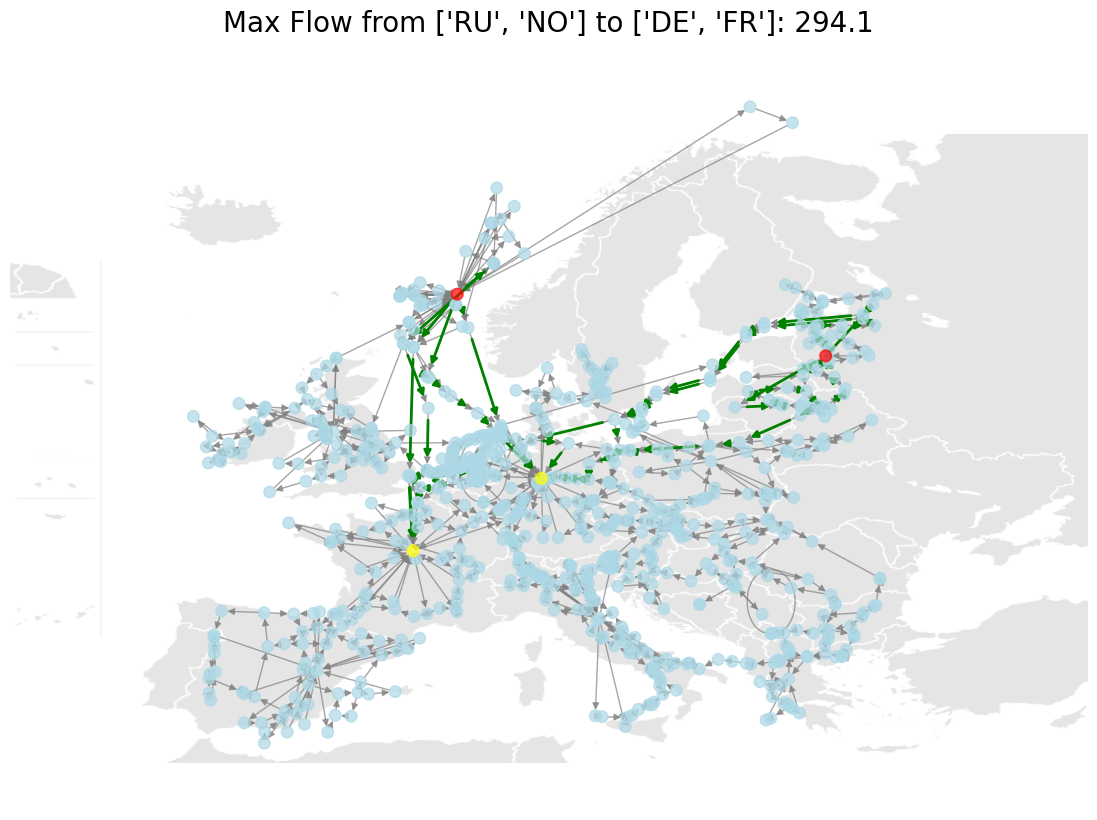

In [9]:
super_sources = ['RU', 'NO']
super_sinks = ['DE', 'FR']

flow_val, flow_dict, flow_edges = max_flow(G, super_sources, super_sinks)